In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from nats import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [14]:
N = 60
K = 3
D = 2

## Model Parameters
MCMC_SIZE = 50
SAMPLE_SIZE = 1
NUM_STATS = 1 + 2 * D
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
CUDA = torch.cuda.is_available()
PATH = 'gibbs-all-NG-init-z'

In [15]:
Xs = torch.from_numpy(np.load('gmm_dataset/obs.npy')).float()
STATES = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
OBS_MU = torch.from_numpy(np.load('gmm_dataset/obs_mu.npy')).float()
OBS_SIGMA = torch.from_numpy(np.load('gmm_dataset/obs_sigma.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

prior_mu = torch.zeros((K, D))
prior_nu = torch.ones((K, D)) * 0.5
prior_alpha = torch.ones((K, D)) * 3
prior_beta = torch.ones((K, D)) * 3
prior_pi = torch.ones(K) * (1. / K)
if CUDA:
    prior_mu = prior_mu.cuda()
    prior_nu = prior_nu.cuda()
    prior_alpha = prior_alpha.cuda()
    prior_beta = prior_beta.cuda()
    prior_pi = prior_pi.cuda()

In [16]:
def gibbs(obs, iterations):
    LLs = []
    for m in range(iterations):
        if m == 0:
            states = cat(torch.ones(K)* (1. / K)).sample((SAMPLE_SIZE, BATCH_SIZE, N,)).cuda()
        else:
            states = q_z['zs'].value
        ## update tau and mu -- global variables
        stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
        q_eta, p_eta = update_eta(stat1, stat2, stat3)
        q_z, p_z = update_z(obs, q_eta, p_eta)
        log_joint = Log_joint(p_eta, p_z)
        LLs.append(log_joint)
    return q_eta, q_z, LLs
    
        
        
def update_eta(stat1, stat2, stat3):
    q_eta = probtorch.Trace()
    p_eta = probtorch.Trace()
    post_mu, post_nu, post_alpha, post_beta = Post_mu_tau(stat1, stat2, stat3, prior_mu, prior_nu, prior_alpha, prior_beta, D)
    q_eta.gamma(post_alpha, 
                post_beta,
                name='precisions')
    obs_tau = q_eta['precisions'].value
    p_eta.gamma(prior_alpha, 
                prior_beta,
                value=obs_tau,
                name='precisions')

    q_eta.normal(post_mu,
                 1. / (post_nu * obs_tau).sqrt(),
                 name='means')
    obs_mu = q_eta['means'].value
    p_eta.normal(prior_mu,
                 1. / (prior_nu * obs_tau).sqrt(),
                 value=obs_mu,
                 name='means')  
    return q_eta, p_eta

def update_z(obs, q_eta, p_eta):
    q_z = probtorch.Trace()
    p_z = probtorch.Trace()
    obs_tau = q_eta['precisions'].value
    obs_mu = q_eta['means'].value
    post_pi = Post_z(obs, obs_tau, obs_mu, N, K)
    _ = q_z.variable(cat, probs=post_pi, name='zs')        
    _ = p_z.variable(cat, probs=prior_pi, value=q_z['zs'], name='zs')
    return q_z, p_z

def Log_joint(p_eta, p_z):
    obs_mu = p_eta['means'].value
    obs_tau = p_eta['precisions'].value
    obs_sigma = 1. / obs_tau.sqrt()
    states = p_z['zs'].value
    labels = states.argmax(-1)
    labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
    obs_mu_expand = torch.gather(obs_mu, 2, labels_flat)
    obs_sigma_expand = torch.gather(obs_sigma, 2, labels_flat)
    log_obs = Normal(obs_mu_expand, obs_sigma_expand).log_prob(obs).sum(-1).sum(-1) ## S * B
    return log_obs + p_eta['means'].log_prob.sum(-1).sum(-1) + p_eta['precisions'].log_prob.sum(-1).sum(-1) + p_z['zs'].log_prob.sum(-1)
  

In [52]:
def plot_ll(LLs, batch_size):
    fig = plt.figure(figsize=(15,15))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        ax.plot(LLs[:, b].data.numpy())
        
def plot_samples(obs, q_eta, q_z, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(15,15))
    xs = obs[0].cpu()
    zs = q_z['zs'].value[0].cpu()
    mu_means = q_eta['means'].dist.loc[0].cpu().data.numpy()
    tau_means = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b].data.numpy()
        z = zs[b].data.numpy()
        mu = mu_means[b].reshape(K, D)
        sigma2 = 1. / tau_means[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(sigma2[k]**2)
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-15, 15])
        ax.set_xlim([-15, 15])
#     plt.savefig('results/modes-' + PATH + '.svg')

In [56]:
BATCH_SIZE = 25
MCMC_SIZE = 10
indices = torch.randperm(NUM_SEQS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
obs = Xs[batch_indices]
obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    obs =obs.cuda()
q_eta, q_z, LLs = gibbs(obs, MCMC_SIZE)
LLs = torch.cat(LLs, 0).cpu()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


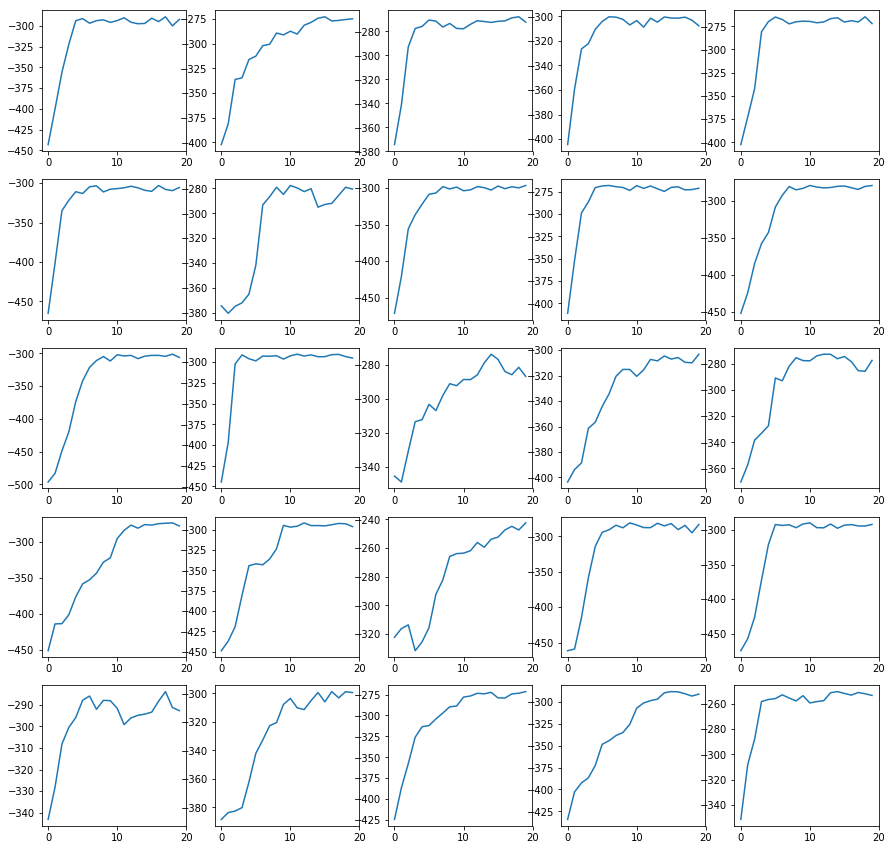

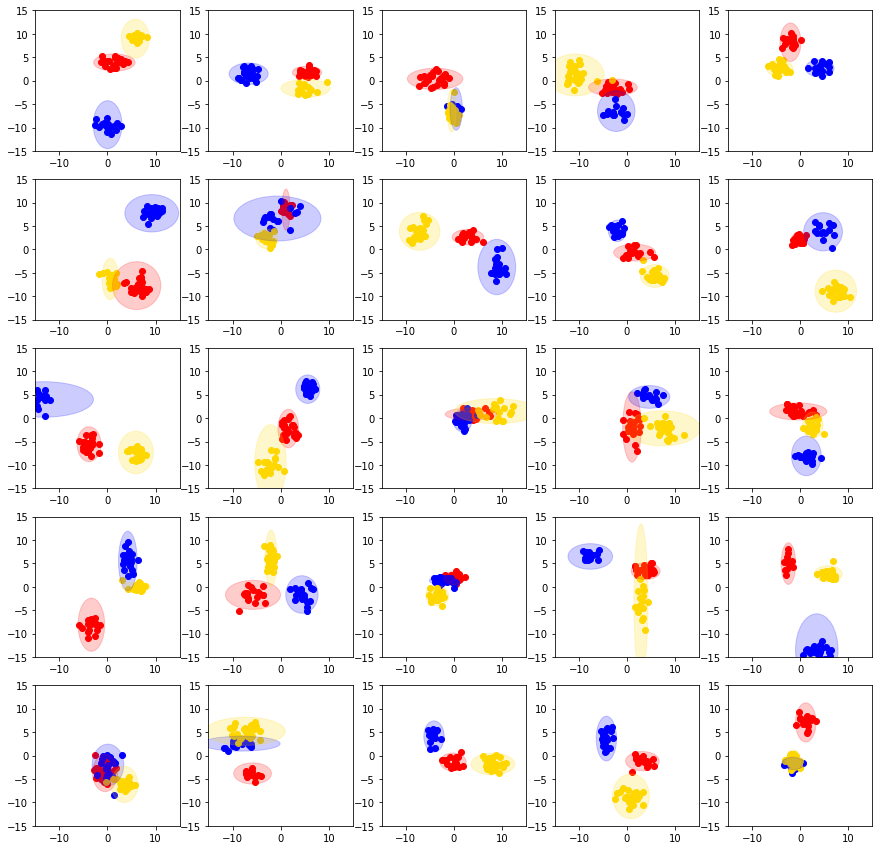

In [64]:
MCMC_SIZE = 20
q_eta, q_z, LLs = gibbs(obs, MCMC_SIZE)
LLs = torch.cat(LLs, 0).cpu()
plot_ll(LLs, BATCH_SIZE)
plot_samples(obs, q_eta, q_z, BATCH_SIZE)
%time